# <h1 style="text-align: center; font-size: 36px; color: #3498db; font-weight: bold;">Prosody Application</h1>
## <h2 style="text-align: center; font-size: 28px; color: #2ecc71; font-weight: bold;">Emotion Recognation</h2>


In [6]:
###########################
#@author: Eyad Alkostantini
###############################################
# loding the model, weights, scaler and encoder
###############################################

import pickle
import pyaudio
import numpy as np
import librosa
import wave
import pandas as pd
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

In [7]:
import gdown
import os 
#########################################################################################################
# Cloud Folder
if not os.path.exists("Output"):
    folder_url =r"https://drive.google.com/drive/folders/1EZL6Ejoa5GH8DzoZcjvRAonlgWznEh14?usp=drive_link" #./Output
    gdown.download_folder(folder_url)
##########################################################################################################


Retrieving folder contents


Processing file 184himIOZRklBNrDMV499JomaeJFUziVW Prosody_Encoder.pickle
Processing file 1uVV7zKezD5DbKsX2ynA8d8wfTy-P7B_x Prosody_Model.keras
Processing file 1np1afenKhtnNgYyEFtxH_No0HJuhOHlL Prosody_Scaler.pickle


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=184himIOZRklBNrDMV499JomaeJFUziVW
To: d:\FH_Reutlingen\Eyad\Output\Prosody_Encoder.pickle
100%|██████████| 587/587 [00:00<?, ?B/s] 
Downloading...
From: https://drive.google.com/uc?id=1uVV7zKezD5DbKsX2ynA8d8wfTy-P7B_x
To: d:\FH_Reutlingen\Eyad\Output\Prosody_Model.keras
100%|██████████| 21.0M/21.0M [00:02<00:00, 10.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1np1afenKhtnNgYyEFtxH_No0HJuhOHlL
To: d:\FH_Reutlingen\Eyad\Output\Prosody_Scaler.pickle
100%|██████████| 57.5k/57.5k [00:00<00:00, 3.50MB/s]
Download completed


In [8]:
import tensorflow as tf 

prosody_model = tf.keras.models.load_model('Prosody_Model.keras')
print ("Prosody Model has been loaded")

# loding the Scaler
with open("./Output/Prosody_Scaler.pickle", 'rb') as f:
    prosody_scaler = pickle.load(f)

# loding the Encoder    
with open("./Output/Prosody_Encoder.pickle", 'rb') as f:
    prosody_Encoder = pickle.load(f)

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
#####################################
# geting the features from the voice
#####################################

## ZCR: Zero Crossing Rate: The rate of sign changes of the signal during the duration of a particular frame
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

## RMS: root mean square value
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

## MFCC: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

## Extraxing the features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result

##############################
# features extraxtion function
##############################
def get_features(path):
    data, sr= librosa.load(path, duration=2.5, offset=0) # Extract for 2.5 seconds
    result=extract_features(data)
    result=np.array(result)
    result = np.reshape(result, (1, -1))
    
    result = prosody_scaler.transform(result)  # Scaler
    #final_result=np.expand_dims(result, axis=2)     # Reshape for our cnn Model   
    #print("final shape for predection", result.shape)
    return result

######################
# Prediction function
######################
def prediction(path):
    result = get_features(path)
    prediction = prosody_model.predict(result)
    y_prediction = prosody_Encoder.inverse_transform(prediction.reshape(1, -1))
    predicted_class = y_prediction[0][0]
    # class probabilities
    predicted_probs = prediction[0]
    # class names from encoder
    class_names = prosody_Encoder.categories_[0]
    ''''
    # Print predicted class and probabilities for all classes
    print("Predictions for all classes:")
    for label, prob in zip(class_names, predicted_probs):
        print(f"{label}: {prob*100:.2f}%")
    '''
    return predicted_class, predicted_probs


## <h2 style="text-align: left; font-size: 28px; color: #2ecc71; font-weight: bold;">Real-Time Prediction</h2>

In [3]:
#####################
# Test visualisations
#####################

# def visualize_emotion_prediction(predicted_class, predicted_probs):
#     # class names
#     class_names = ['Noise','angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    
#     # Plotting
#     plt.figure(figsize=(10, 6))
#     bars = plt.bar(class_names, predicted_probs * 100, color='skyblue')
#     plt.title('Emotion Prediction')
#     plt.xlabel('Emotion')
#     plt.ylabel('Probability (%)')
#     plt.ylim(0, 100)
#     plt.xticks(rotation=45)
    
#     #  percentage
#     for i, bar in enumerate(bars):
#         plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{predicted_probs[i]*100:.2f}%', ha='center', va='bottom')
    
#     plt.show()

# def visualize_emotion_prediction_pie(predicted_probs):
#     # Get class names
#     class_names = ['Noise','angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

#     # Plotting
#     plt.figure(figsize=(4, 4))
#     plt.pie(predicted_probs * 100, labels=class_names, autopct='%1.1f%%', colors=plt.cm.tab10.colors, startangle=140)
#     plt.title('Emotion Prediction')
#     plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
#     # Rotate the labels
#     plt.gca().set_aspect('equal')
#     plt.gca().set_xlim([-1.2, 1.2])
#     plt.gca().set_ylim([-1.2, 1.2])
#     plt.xticks(rotation=35)
#     plt.yticks(rotation=35)
    
#     plt.show()


# # Russell's Circumplex Model
# emotions = {
#     'Noise': (0.5, -1),
#     'angry': (-1, 1),
#     'disgust': (-0.7, 0.7),
#     'fear': (0, 1),
#     'happy': (1, 1),
#     'neutral': (0, 0),
#     'sad': (-1, -1),
#     'surprise': (1, 0)
# }

# def plot_emotion_circumplex(predicted_class):
#     # Plotting
#     plt.figure(figsize=(8, 8))
#     plt.title("Russell's Emotion Circumplex Model")
#     plt.xlabel('Valence')
#     plt.ylabel('Arousal')
#     plt.xlim(-1.2, 1.2)
#     plt.ylim(-1.2, 1.2)
    
#     # Plot emotions
#     for emotion, (x, y) in emotions.items():
#         plt.scatter(x, y, color='gray')
#         plt.text(x, y, emotion, fontsize=9, ha='center', va='center')
    
#     #  predicted emotion
#     if predicted_class in emotions:
#         x_pred, y_pred = emotions[predicted_class]
#         plt.scatter(x_pred, y_pred, color='red', marker='o', s=100, label='Predicted Emotion')
#         plt.text(x_pred, y_pred, predicted_class, fontsize=9, ha='center', va='bottom')
    
#     plt.legend()
#     plt.grid(True)
#     plt.show()


##############################
# # Recording configuration
##############################

# RECORD_SECONDS = 2.5  # recording duration
# FORMAT = pyaudio.paFloat32
# CHANNELS = 1
# RATE = 44100
# CHUNK = 1024
# CHUNK_SIZE = 1024
# OUTPUT_FILE = "recorded_audio.wav"
# #OUTPUT_FILE = "C:\Users\Alkostantini\Downloads\recorded_audio.wav"


# # start loop
# try:
#     while True:
#         print("Listening...")
#         #data = stream.read(CHUNK)
#         #audio_data = np.frombuffer(data, dtype=np.float32)
        
#         audio = pyaudio.PyAudio()
#         stream = audio.open(format=FORMAT, channels=CHANNELS,
#                     rate=RATE, input=True,
#                     frames_per_buffer=CHUNK)
#         frames = []

#         # Recording 
#         for i in range(0, int(RATE / CHUNK_SIZE * RECORD_SECONDS)):
#             data = stream.read(CHUNK_SIZE)
#             frames.append(data)



        
#         # Stop stream
#         stream.stop_stream()
#         stream.close()
#         audio.terminate()
        
#         # Saving the audio
#         with wave.open(OUTPUT_FILE, 'wb') as wf:
#             wf.setnchannels(CHANNELS)
#             wf.setsampwidth(audio.get_sample_size(FORMAT))
#             wf.setframerate(RATE)
#             wf.writeframes(b''.join(frames))

       
        
#         voice, probs = prediction(OUTPUT_FILE)
#         # Call after prediction
#         print("Emotions:")
#         #visualize_emotion_prediction(voice, probs)
#         #visualize_emotion_prediction_pie(probs)
#         plot_emotion_circumplex(voice)

        
# except KeyboardInterrupt:
#     print("Stopped")
#     stream.stop_stream()
#     stream.close()
#     audio.terminate()


Listening...
1/1 [==============================] - 0s 36ms/step
Listening...
1/1 [==============================] - 0s 38ms/step
Listening...
1/1 [==============================] - 0s 38ms/step
Listening...
1/1 [==============================] - 0s 39ms/step
Listening...
1/1 [==============================] - 0s 37ms/step


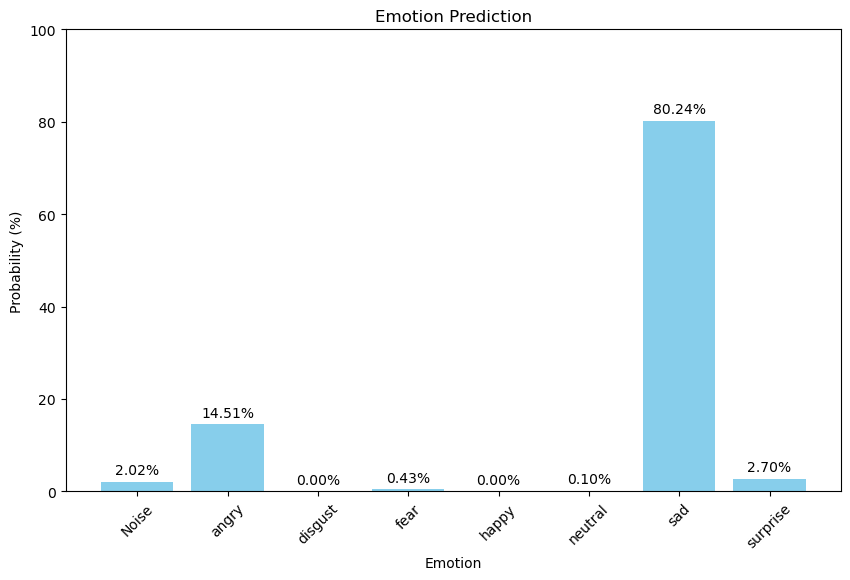

In [12]:
#######################
# Real-Time prediction
#######################

class EmotionPlotter:
    def __init__(self, root, update_callback):
        self.root = root
        self.root.title("Emotion Prediction")
        self.update_callback = update_callback
        self.class_names = ['Noise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=45)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

        ########################
        # start and stop buttons
        ########################
        self.start_button = tk.Button(self.root, text="Start", command=self.start_visualization)
        self.start_button.pack(side=tk.LEFT)
        self.stop_button = tk.Button(self.root, text="Stop", command=self.stop_visualization)
        self.stop_button.pack(side=tk.LEFT)
        self.stop_button['state'] = tk.DISABLED  # Initially disable stop button      
        self.visualizing = False         # track of visualization state

        
    def start_visualization(self):
        self.visualizing = True
        self.start_button['state'] = tk.DISABLED
        self.stop_button['state'] = tk.NORMAL
        self.update_loop()
        
    def stop_visualization(self):
        self.visualizing = False
        self.start_button['state'] = tk.NORMAL
        self.stop_button['state'] = tk.DISABLED
        
    def update_loop(self):
        if self.visualizing:
            #########################
            # Recording configuration
            #########################
            RECORD_SECONDS = 2.5  # recording duration
            FORMAT = pyaudio.paInt16
            CHANNELS = 1
            RATE = 44100
            CHUNK = 1024
            CHUNK_SIZE = 1024
            OUTPUT_FILE = "recorded_audio.wav"
            #OUTPUT_FILE = r"C:\Users\Alkostantini\Downloads\recorded_audio.wav"
            
            ########################
            # Start recording audio
            ########################
            print("Listening...")
            audio = pyaudio.PyAudio()
            stream = audio.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)
            frames = []
            # Recording 
            for i in range(0, int(RATE / CHUNK_SIZE * RECORD_SECONDS)):
                data = stream.read(CHUNK_SIZE)
                frames.append(data)
            # Stop recording
            stream.stop_stream()
            stream.close()
            audio.terminate()
            # Saving audio
            with wave.open(OUTPUT_FILE, 'wb') as wf:
                wf.setnchannels(CHANNELS)
                wf.setsampwidth(audio.get_sample_size(FORMAT))
                wf.setframerate(RATE)
                wf.writeframes(b''.join(frames))

            ####################
            # Perform prediction
            ####################
            predicted_class, predicted_probs = prediction(OUTPUT_FILE)
            # callback
            self.update_callback(self, predicted_class, predicted_probs)
            # update 
            self.root.after(2500, self.update_loop)  # Update every 2.5 seconds

    ########################
    # update Plot
    ########################
    def update_plot(self, predicted_probs):
        self.ax.clear()
        bars = self.ax.bar(self.class_names, predicted_probs * 100, color='skyblue')
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=45)

        for i, bar in enumerate(bars):
            self.ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{predicted_probs[i]*100:.2f}%', ha='center', va='bottom')

        self.canvas.draw()

def visualize_emotion_prediction(plotter, predicted_class, predicted_probs):
    plotter.update_plot(predicted_probs)



# callback function
root = tk.Tk() #root window
plotter = EmotionPlotter(root, visualize_emotion_prediction)
root.mainloop()

Listening...
1/1 [==============================] - 0s 43ms/step
Listening...
1/1 [==============================] - 0s 41ms/step
Listening...
1/1 [==============================] - 0s 40ms/step
Listening...
1/1 [==============================] - 0s 40ms/step
Listening...
1/1 [==============================] - 0s 37ms/step
Listening...
1/1 [==============================] - 0s 43ms/step
Listening...
1/1 [==============================] - 0s 44ms/step
Listening...
1/1 [==============================] - 0s 45ms/step
Listening...
1/1 [==============================] - 0s 40ms/step
Listening...
1/1 [==============================] - 0s 39ms/step
Listening...
1/1 [==============================] - 0s 39ms/step
Listening...
1/1 [==============================] - 0s 45ms/step
Listening...
1/1 [==============================] - 0s 40ms/step
Listening...
1/1 [==============================] - 0s 37ms/step
Listening...
1/1 [==============================] - 0s 41ms/step
Listening...
1/1 [=======

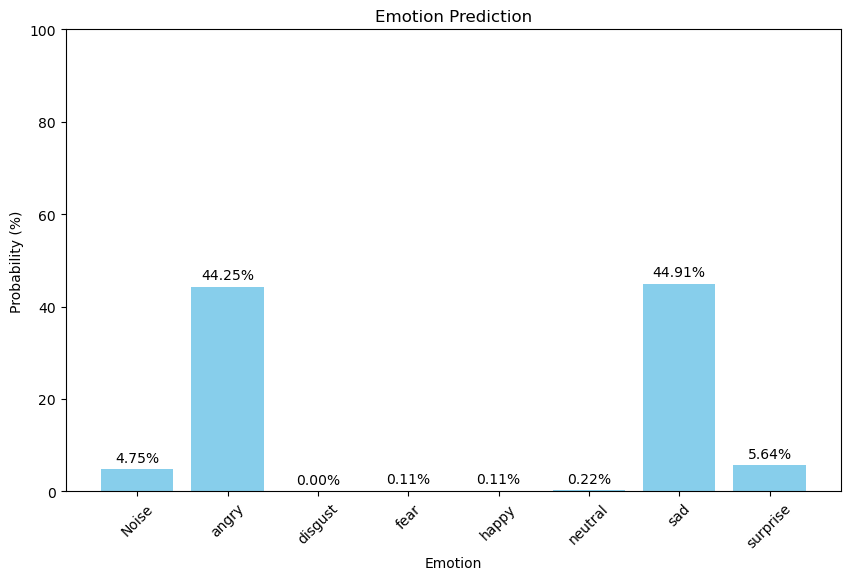

In [13]:
#######################
# Real-Time prediction
#######################

class EmotionPlotter:
    def __init__(self, root, update_callback):
        self.root = root
        self.root.title("Emotion Prediction")
        self.update_callback = update_callback
        self.class_names = ['Noise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.fig, self.ax = plt.subplots(figsize=(10, 6))
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=45)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        #########################
        # Recording configuration
        #########################
        self.RECORD_SECONDS = 2.5  # recording duration
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.CHUNK = 1024
        self.CHUNK_SIZE = 1024
        self.OUTPUT_FILE = "recorded_audio.wav"
        #OUTPUT_FILE = r"C:\Users\Alkostantini\Downloads\recorded_audio.wav"
        ########################
        # start and stop buttons
        ########################
        self.start_button = tk.Button(self.root, text="Start", command=self.start_visualization)
        self.start_button.pack(side=tk.LEFT)
        self.stop_button = tk.Button(self.root, text="Stop", command=self.stop_visualization)
        self.stop_button.pack(side=tk.LEFT)
        self.stop_button['state'] = tk.DISABLED  # Initially disable stop button      
        self.visualizing = False                 # track of visualization state

        
    def start_visualization(self):
        self.visualizing = True
        self.start_button['state'] = tk.DISABLED
        self.stop_button['state'] = tk.NORMAL
        self.update_loop()
        
    def stop_visualization(self):
        self.visualizing = False
        self.start_button['state'] = tk.NORMAL
        self.stop_button['state'] = tk.DISABLED
        
    def update_loop(self):
        if self.visualizing:
            ########################
            # Start recording audio
            ########################
            print("Listening...")
            audio = pyaudio.PyAudio()
            stream = audio.open(format=self.FORMAT, channels=self.CHANNELS, rate=self.RATE, input=True, frames_per_buffer=self.CHUNK)
            frames = []
            # Recording 
            for i in range(0, int(self.RATE / self.CHUNK_SIZE * self.RECORD_SECONDS)):
                data = stream.read(self.CHUNK_SIZE)
                frames.append(data)
            # Stop recording
            stream.stop_stream()
            stream.close()
            audio.terminate()
            # Saving audio
            with wave.open(self.OUTPUT_FILE, 'wb') as wf:
                wf.setnchannels(self.CHANNELS)
                wf.setsampwidth(audio.get_sample_size(self.FORMAT))
                wf.setframerate(self.RATE)
                wf.writeframes(b''.join(frames))

            ####################
            # Perform prediction
            ####################
            predicted_class, predicted_probs = prediction(self.OUTPUT_FILE)
            # callback
            self.update_callback(self, predicted_class, predicted_probs)
            # update 
            self.root.after(2500, self.update_loop)  # Update every 2.5 seconds

    ########################
    # Update Plot
    ########################
    def update_plot(self, predicted_probs):
        self.ax.clear()
        bars = self.ax.bar(self.class_names, predicted_probs * 100, color='skyblue')
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=45)
        for i, bar in enumerate(bars):
            self.ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{predicted_probs[i]*100:.2f}%', ha='center', va='bottom')
        self.canvas.draw()

def visualize_emotion_prediction(plotter, predicted_class, predicted_probs):
    plotter.update_plot(predicted_probs)



# callback function
root = tk.Tk() #root window
plotter = EmotionPlotter(root, visualize_emotion_prediction)
root.mainloop()